In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import glob
import config
import re
import jax.numpy as jnp
import nicewebrl
from typing import List
from collections import defaultdict
from flax import serialization
import polars as pl
from glob import glob


import jax

import config
from download_google_data import download_user_files
from experiment_structure import jax_web_env, env_params

/Users/wilka/miniforge3/envs/nicewebrl-examples/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling environment reset and step functions.
	reset time: 0.2657029628753662
	step time: 1.5618939399719238
Compiling multi-render function.
	time: 0.015024185180664062


In [3]:
rng = jax.random.PRNGKey(0)
example_timestep = jax_web_env.reset(rng, env_params)

In [31]:

bucket_name = config.BUCKET_NAME
human_data_pattern = "*"
download_user_files(
    bucket_name=bucket_name,
    pattern=human_data_pattern,
    destination_folder=f"{config.DATA_DIR}",
)
files = f"{config.DATA_DIR}/*{human_data_pattern}"
files = list(set(glob(files)))


File already exists: 
	 ./user_data/user_data_1002454722.json
File already exists: 
	 ./user_data/user_data_1002454722.msgpack
File already exists: 
	 ./user_data/user_data_1226677903.json
File already exists: 
	 ./user_data/user_data_1226677903.msgpack
File already exists: 
	 ./user_data/user_data_1289133514.json
File already exists: 
	 ./user_data/user_data_1289133514.msgpack
File already exists: 
	 ./user_data/user_data_144109074.json
File already exists: 
	 ./user_data/user_data_144109074.msgpack
File already exists: 
	 ./user_data/user_data_1445292460.json
File already exists: 
	 ./user_data/user_data_1445292460.msgpack
Downloaded: 
	 from: data/user_data_1497249019.json 
	 to: ./user_data/user_data_1497249019.json
Downloaded: 
	 from: data/user_data_1497249019.msgpack 
	 to: ./user_data/user_data_1497249019.msgpack
File already exists: 
	 ./user_data/user_data_1701072164.json
File already exists: 
	 ./user_data/user_data_1701072164.msgpack
File already exists: 
	 ./user_data/user

In [32]:
pattern = '*'
metadata_files = sorted(glob(f"{config.DATA_DIR}/*{pattern}*.json"))
data_files = sorted(glob(f"{config.DATA_DIR}/*{pattern}.msgpack"))
# data_files
assert len(data_files)==len(metadata_files), "either data or metadata is missing for a user"
metadata_files[:2], len(metadata_files)

(['./user_data/user_data_1002454722.json',
  './user_data/user_data_1226677903.json'],
 29)

In [33]:
def get_user_id(filepath):
    pattern = r'\d+'
    match = re.search(pattern, file_path)
    if match:
        return match.group()


def seperate_data_into_episodes(data: List[dict]):
  """This function will group episodes by the values in the datum dictionaries
  """
  key_to_episodes_unprocessed = defaultdict(list)
  episode_idx = -1
  keys = set()
  all_episode_information = dict()
  # first group all of the data based on which (stage, block) its in
  for datum in data:
    # This function will be used to group datapoints of an individual episode
    stage_episode_idx=datum["metadata"]["nepisodes"]
    stage_idx = datum['stage_idx']
    key = f"stage={stage_idx}_episode={stage_episode_idx}"
    if key not in keys:
      episode_idx += 1
      keys.add(key)
    info = dict(
        episode_idx=episode_idx,
        stage_episode_idx=stage_episode_idx,
        stage_idx=stage_idx)

    key_to_episodes_unprocessed[key].append(datum)
    all_episode_information[key] = info
  return key_to_episodes_unprocessed, all_episode_information

def deserialize_timestep(datum):
  timestep = datum["data"]["timestep"]
  timestep = serialization.from_bytes(example_timestep, timestep)

  return timestep

df_data = []
for metadatafile, data_file in zip(metadata_files, data_files):

    # extract relevant metadata
    with open(metadatafile, 'r') as f:
        metadata = json.load(f)
    user_data = dict(
        user_id = metadata['user_storage']['seed'],
        model_chosen = metadata['user_storage']['selected_model'],
    )
    
    data = nicewebrl.load_data(data_file)

    
    # feed form data from user
    feedback_data = data[-1]['data']
    if feedback_data is None:
        continue
    print(f"user_{user_data['user_id']}_feedback: {metadata['feedback']}")
    df_data.append(dict(**user_data, stage_type='feedback', **feedback_data))
    

    # get episode information
    key_to_episodes_unprocessed, episode_information = seperate_data_into_episodes(data[:-1])
    episode_data = [None] * len(key_to_episodes_unprocessed.keys())

    for key in key_to_episodes_unprocessed.keys():
        episode_idx = episode_information[key]["episode_idx"]
        raw_episode_trials_data = key_to_episodes_unprocessed[key]

        actions = jnp.asarray([datum["data"]["action_idx"] for datum in raw_episode_trials_data])

        # Compute reaction times (T)
        reaction_times = [nicewebrl.compute_reaction_time(datum['data']) for datum in raw_episode_trials_data]
        reaction_times = jnp.asarray(reaction_times)

        # Compute episode data (T)
        timesteps = [
          deserialize_timestep(datum) for datum in raw_episode_trials_data
        ]
        timesteps = jax.tree.map(lambda *v: jnp.stack(v), *timesteps)

        df_data.append(dict(
            total_reward=timesteps.reward.sum(),
            success=(timesteps.reward > .5).any(-1),  
            reaction_times=str(reaction_times),
            stage_type='interaction',
            **user_data
        ))
            

df = pl.DataFrame(df_data)
df

user_1002454722_feedback: GOOD
user_1226677903_feedback: 
user_1289133514_feedback: GOOD
user_144109074_feedback: nice
user_1445292460_feedback: The AI didn't work at all. I had no idea what to do.
user_1497249019_feedback: GOOD
user_1701072164_feedback: I could not figure out how to succeed at all. I didn't see many of the things I was supposed to interact with and I was very confused. Maybe that was the point?
user_1936497927_feedback: 
user_2194745742_feedback: good
user_2385584245_feedback: NICE

user_2499340451_feedback: 
user_2648624090_feedback: 
user_2894167223_feedback: good
user_2961002067_feedback: good
user_2962671080_feedback: 
user_3027597029_feedback: good
user_3038489895_feedback: I had a tough time navigating the maze, I think a practice session would have been nice. It felt buggy to me but maybe it was supposed to feel that way. I asked the AI a few questions about how to navigate the maze and it wasn't that helpful.
user_3205079761_feedback: 
user_3253322768_feedback

user_id,model_chosen,stage_type,How helpful was the AI?,How human-like was the AI?,total_reward,success,reaction_times
i64,str,str,i64,i64,f64,f64,str
1002454722,"""claude""","""feedback""",4,5,null,null,null
1002454722,"""claude""","""interaction""",null,null,0.0,0.0,"""[2846. 424. 384. 320. 225.…"
1002454722,"""claude""","""interaction""",null,null,0.0,0.0,"""[531. 296. 200. 431. 497. 192.…"
1002454722,"""claude""","""interaction""",null,null,0.0,0.0,"""[ 40. 233. 190. 376. 265.…"
1226677903,"""gemini""","""feedback""",3,3,null,null,null
…,…,…,…,…,…,…,…
779345697,"""chatgpt""","""interaction""",null,null,0.0,0.0,"""[17286. 1174. 1529. 453. …"
813426961,"""chatgpt""","""feedback""",3,4,null,null,null
813426961,"""chatgpt""","""interaction""",null,null,0.0,0.0,"""[5.97830e+04 9.68000e+02 1.376…"


In [34]:
interaction_counts = df.filter(stage_type='feedback').group_by('model_chosen').agg(
    pl.len().alias('total_interactions')
).sort('total_interactions', descending=True)
interaction_counts

model_chosen,total_interactions
str,u32
"""gemini""",11
"""chatgpt""",10
"""claude""",8


In [35]:
interaction_counts['total_interactions'].sum()

29

In [36]:
success_sum = df.filter(pl.col('stage_type') == 'interaction').group_by('model_chosen').agg(
    pl.col('success').sum().alias('success_total')
).sort('success_total', descending=True)
success_sum

model_chosen,success_total
str,f64
"""gemini""",2.0
"""chatgpt""",1.0
"""claude""",0.0


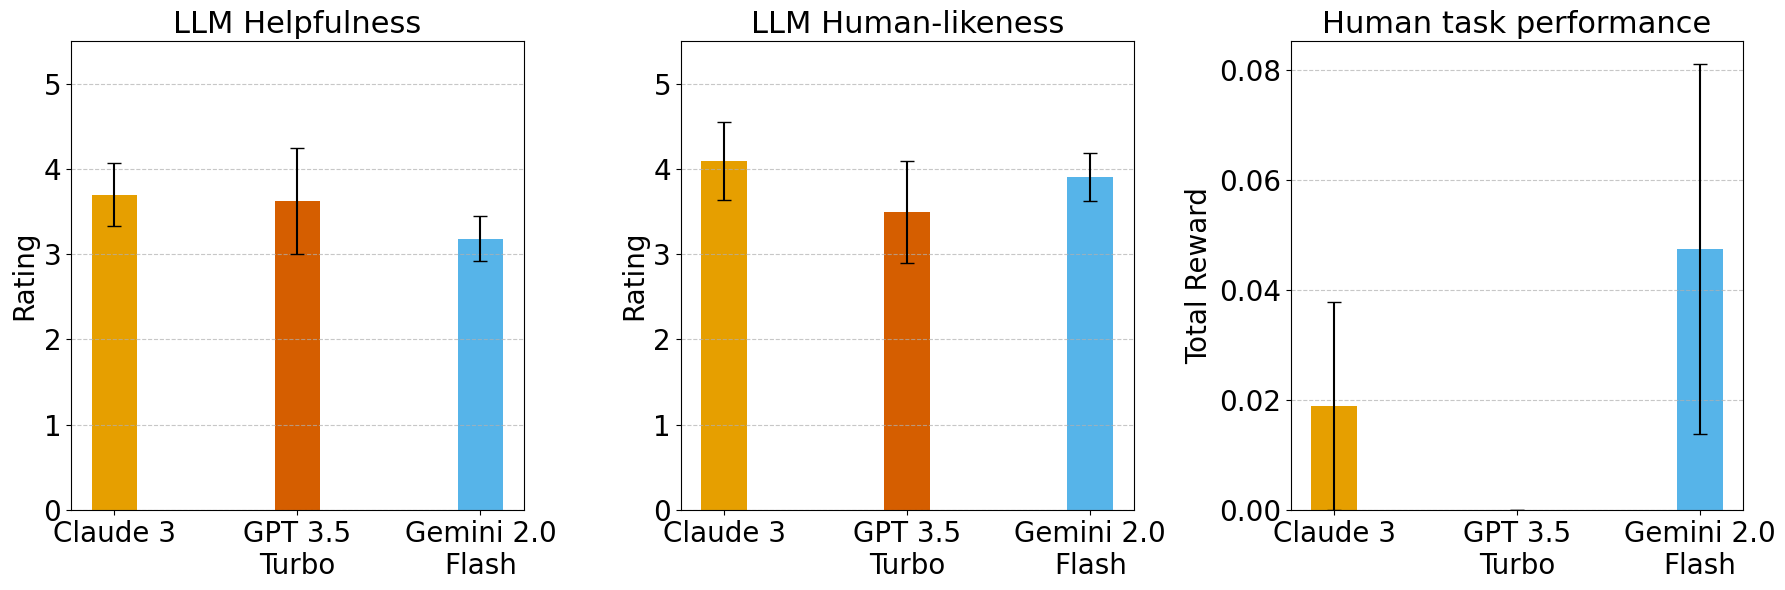

In [39]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import math
# Assuming your dataframe is named 'df'
# Filter for feedback stage type
feedback_df = df.filter(pl.col("stage_type") == "feedback")
# Get unique models
models = df["model_chosen"].unique().to_list()
models = sorted(models)

# Model name mapping
model_display_names = ["Claude 3", "GPT 3.5\nTurbo", "Gemini 2.0\nFlash"]  # New display names

# Set up the plot with 3 columns (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Width of bars and positions
bar_width = 0.25
index = np.arange(len(models))  # One bar per model in each plot
# Colors for different models
nice_colors = {
  "orange": (230 / 255, 159 / 255, 0.0),  # human
  "vermillion": (213 / 255, 94 / 255, 0.0),  # preplay
  "sky blue": (86 / 255, 180 / 255, 233 / 255),  # dfs, EVAL_COLOR
  "bluish green": (0.0, 158 / 255, 115 / 255),  # reuse
}
colors = [
    nice_colors['orange'],
    nice_colors['vermillion'],
    nice_colors['sky blue'],
]
# Font sizes
# Get data for helpfulness
helpfulness_vals = []
helpfulness_errs = []
for model in models:
    model_feedback = feedback_df.filter(model_chosen=model)
    help_values = model_feedback["How helpful was the AI?"].drop_nulls()
    
    helpfulness = help_values.mean()
    help_std = help_values.std()
    help_err = help_std / math.sqrt(len(help_values)) if len(help_values) > 1 else 0
        
    helpfulness_vals.append(helpfulness)
    helpfulness_errs.append(help_err)
# Get data for human-likeness
humanlike_vals = []
humanlike_errs = []
for model in models:
    model_feedback = feedback_df.filter(model_chosen=model)
    human_values = model_feedback["How human-like was the AI?"].drop_nulls()
    humanlike = human_values.mean()
    human_std = human_values.std()
    human_err = human_std / math.sqrt(len(human_values)) if len(human_values) > 1 else 0
        
    humanlike_vals.append(humanlike)
    humanlike_errs.append(human_err)
# Get data for total reward
reward_vals = []
reward_errs = []
for model in models:
    model_all = df.filter(pl.col("model_chosen") == model)
    reward_values = model_all["total_reward"].drop_nulls()
    
    reward = reward_values.mean()
    reward_std = reward_values.std()
    reward_err = reward_std / math.sqrt(len(reward_values)) if len(reward_values) > 1 else 0
    reward_vals.append(reward)
    reward_errs.append(reward_err)
small_font_size = 20
title_size = 22
tick_size = 20
axis_label_size = 20
# Plot 1: Helpfulness
axes[0].bar(index, helpfulness_vals, bar_width, color=colors, yerr=helpfulness_errs, capsize=5)
axes[0].set_title('LLM Helpfulness', fontsize=title_size)
axes[0].set_ylabel('Rating', fontsize=axis_label_size)
axes[0].set_xticks(index)
axes[0].set_ylim([0, 5.5])
axes[0].set_xticklabels(model_display_names, fontsize=small_font_size)  # Use new display names
axes[0].tick_params(axis='both', which='major', labelsize=tick_size)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
# Plot 2: Human-likeness
axes[1].bar(index, humanlike_vals, bar_width, color=colors, yerr=humanlike_errs, capsize=5)
axes[1].set_title('LLM Human-likeness', fontsize=title_size)
axes[1].set_ylabel('Rating', fontsize=axis_label_size)
axes[1].set_ylim([0, 5.5])
axes[1].set_xticks(index)
axes[1].set_xticklabels(model_display_names, fontsize=small_font_size)  # Use new display names
axes[1].tick_params(axis='both', which='major', labelsize=tick_size)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
# Plot 3: Total Reward
axes[2].bar(index, reward_vals, bar_width, color=colors, yerr=reward_errs, capsize=5)
axes[2].set_title('Human task performance', fontsize=title_size)
axes[2].set_ylabel('Total Reward', fontsize=axis_label_size)
axes[2].set_xticks(index)
# axes[2].set_ylim([0, .5])
axes[2].set_xticklabels(model_display_names, fontsize=small_font_size)  # Use new display names
axes[2].tick_params(axis='both', which='major', labelsize=tick_size)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
# Add space between subplots and adjust layout
plt.tight_layout()
plt.savefig('model_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()